In [1]:
import time
from pythonbpf import BPF, bpf, section, map, section, bpfglobal
from pythonbpf.maps import HashMap
from pylibbpf import BpfMap
from ctypes import c_void_p, c_int64, c_uint64, c_int32
import matplotlib.pyplot as plt

In [2]:
# BPF map: PID -> count of openat calls
@bpf
@map
def opencounts() -> HashMap:
    return HashMap(key=c_int32, value=c_uint64, max_entries=4096)

@bpf
@section("tracepoint/syscalls/sys_enter_openat")
def trace_open(ctx: c_void_p) -> c_int64:
    pidval = pid()
    one = 1
    prev = opencounts().lookup(pidval)
    if prev:
        prev2 = prev + 1
        opencounts().update(pidval, prev2)
    else:
        opencounts().update(pidval, one)
    return c_int64(0)

@bpf
@bpfglobal
def LICENSE() -> str:
    return "GPL"

# Load
b = BPF()

Module(
    body=[
        FunctionDef(
            name='opencounts',
            args=arguments(
                posonlyargs=[],
                args=[],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Return(
                    value=Call(
                        func=Name(id='HashMap', ctx=Load()),
                        args=[],
                        keywords=[
                            keyword(
                                arg='key',
                                value=Name(id='c_int32', ctx=Load())),
                            keyword(
                                arg='value',
                                value=Name(id='c_uint64', ctx=Load())),
                            keyword(
                                arg='max_entries',
                                value=Constant(value=4096))]))],
            decorator_list=[
                Name(id='bpf', ctx=Load()),
                

Tracking openat() calls for 15s...

Top 10 PIDs by openat() calls:
PID 45983  -> 28648 calls
PID 45985  -> 27865 calls
PID 45984  -> 27849 calls
PID 45992  -> 27468 calls
PID 45979  -> 27428 calls
PID 45977  -> 27227 calls
PID 45993  -> 26994 calls
PID 45989  -> 26953 calls
PID 45981  -> 26942 calls
PID 45988  -> 26743 calls

Anomalous PIDs (suspiciously high openat calls):
PID 45983  -> 28648 calls (outlier)
PID 45985  -> 27865 calls (outlier)
PID 45984  -> 27849 calls (outlier)
PID 45992  -> 27468 calls (outlier)
PID 45979  -> 27428 calls (outlier)
PID 45977  -> 27227 calls (outlier)
PID 45993  -> 26994 calls (outlier)
PID 45989  -> 26953 calls (outlier)
PID 45981  -> 26942 calls (outlier)
PID 45988  -> 26743 calls (outlier)
PID 45987  -> 26721 calls (outlier)
PID 45986  -> 26672 calls (outlier)
PID 45975  -> 26373 calls (outlier)
PID 45991  -> 26305 calls (outlier)
PID 45990  -> 26176 calls (outlier)
PID 45974  -> 26086 calls (outlier)
PID 45980  -> 25662 calls (outlier)
PID 45978  

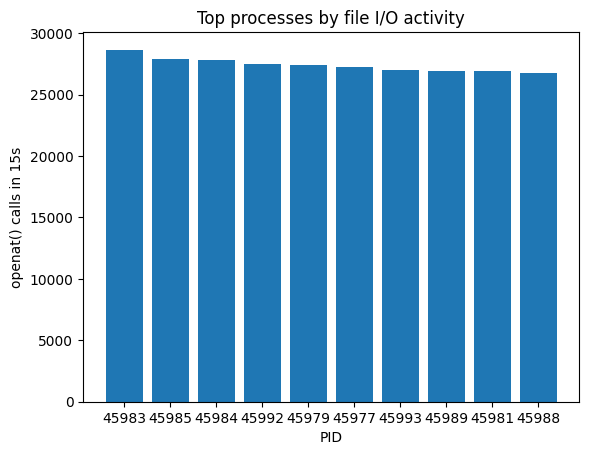

In [4]:
# Expose Python-side map
b.load_and_attach()
open_map = BpfMap(b, opencounts)

print("Tracking openat() calls for 15s...")
time.sleep(15)

# Fetch results
counts = [(pid, open_map[pid]) for pid in open_map.keys()]
counts.sort(key=lambda x: x[1], reverse=True)

# Top 10 processes
top = counts[:10]
print("\nTop 10 PIDs by openat() calls:")
for pid, cnt in top:
    print(f"PID {pid:<6} -> {cnt} calls")

# Detect anomaly: outliers beyond mean+3σ
vals = [cnt for _, cnt in counts]
if vals:
    mean = sum(vals) / len(vals)
    var = sum((x - mean) ** 2 for x in vals) / len(vals)
    std = var ** 0.5
    threshold = mean + 3 * std
    anomalies = [(pid, cnt) for pid, cnt in counts if cnt > threshold]

    if anomalies:
        print("\nAnomalous PIDs (suspiciously high openat calls):")
        for pid, cnt in anomalies:
            print(f"PID {pid:<6} -> {cnt} calls (outlier)")

# Visualization
pids = [pid for pid, _ in top]
vals = [cnt for _, cnt in top]

plt.bar(range(len(top)), vals, tick_label=pids)
plt.xlabel("PID")
plt.ylabel("openat() calls in 15s")
plt.title("Top processes by file I/O activity")
plt.show()